# 5. Policy Gradient
之前介绍的 Q-learning、DQN 及 DQN 改进算法都是基于价值（value-based）的方法，其中 Q-learning 是处理有限状态的算法，而 DQN 可以用来解决连续状态的问题。在强化学习中，除了基于值函数的方法，还有一支非常经典的方法，那就是基于策略（policy-based）的方法。对比两者，基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略，学习过程中并不存在一个显式的策略；而基于策略的方法则是直接显式地学习一个目标策略。策略梯度是基于策略的方法的基础，包括REINFORCE、Actor-Critic等算法。

## 5.1 REINFORCE

In [27]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # 用softmax直接输出动作概率（基于动作价值）
        return F.softmax(self.fc2(x), dim=1)

In [ ]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),
                                          lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样 不再采用
        state = torch.tensor([state], dtype=torch.float).to(self.device)    # (1, state_dim)
        probs = self.policy_net(state)  # 动作概率 (1, action_dim)
        action_dist = torch.distributions.Categorical(probs)    # 创建一个分类分布对象
        action = action_dist.sample()   # 从上述分布中按照概率采样
        return action.item()    # 返回动作

    def update(self, transition_dict):
        # 从buffer 采样
        reward_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()  # 将优化器的旧缓存梯度清零
        for i in reversed(range(len(reward_list))):  # 从最后一步算起
            reward = reward_list[i]
            state = torch.tensor([state_list[i]],
                                 dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)
            # 被选动作的对数概率 action是从action_list选出来的已经执行的动作
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

In [7]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma,
                  device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action) # 接收5个返回值
                done = terminated or truncated  # 新的 done 判断方式
                
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:05<00:00, 18.52it/s, episode=1000, return=483.500]


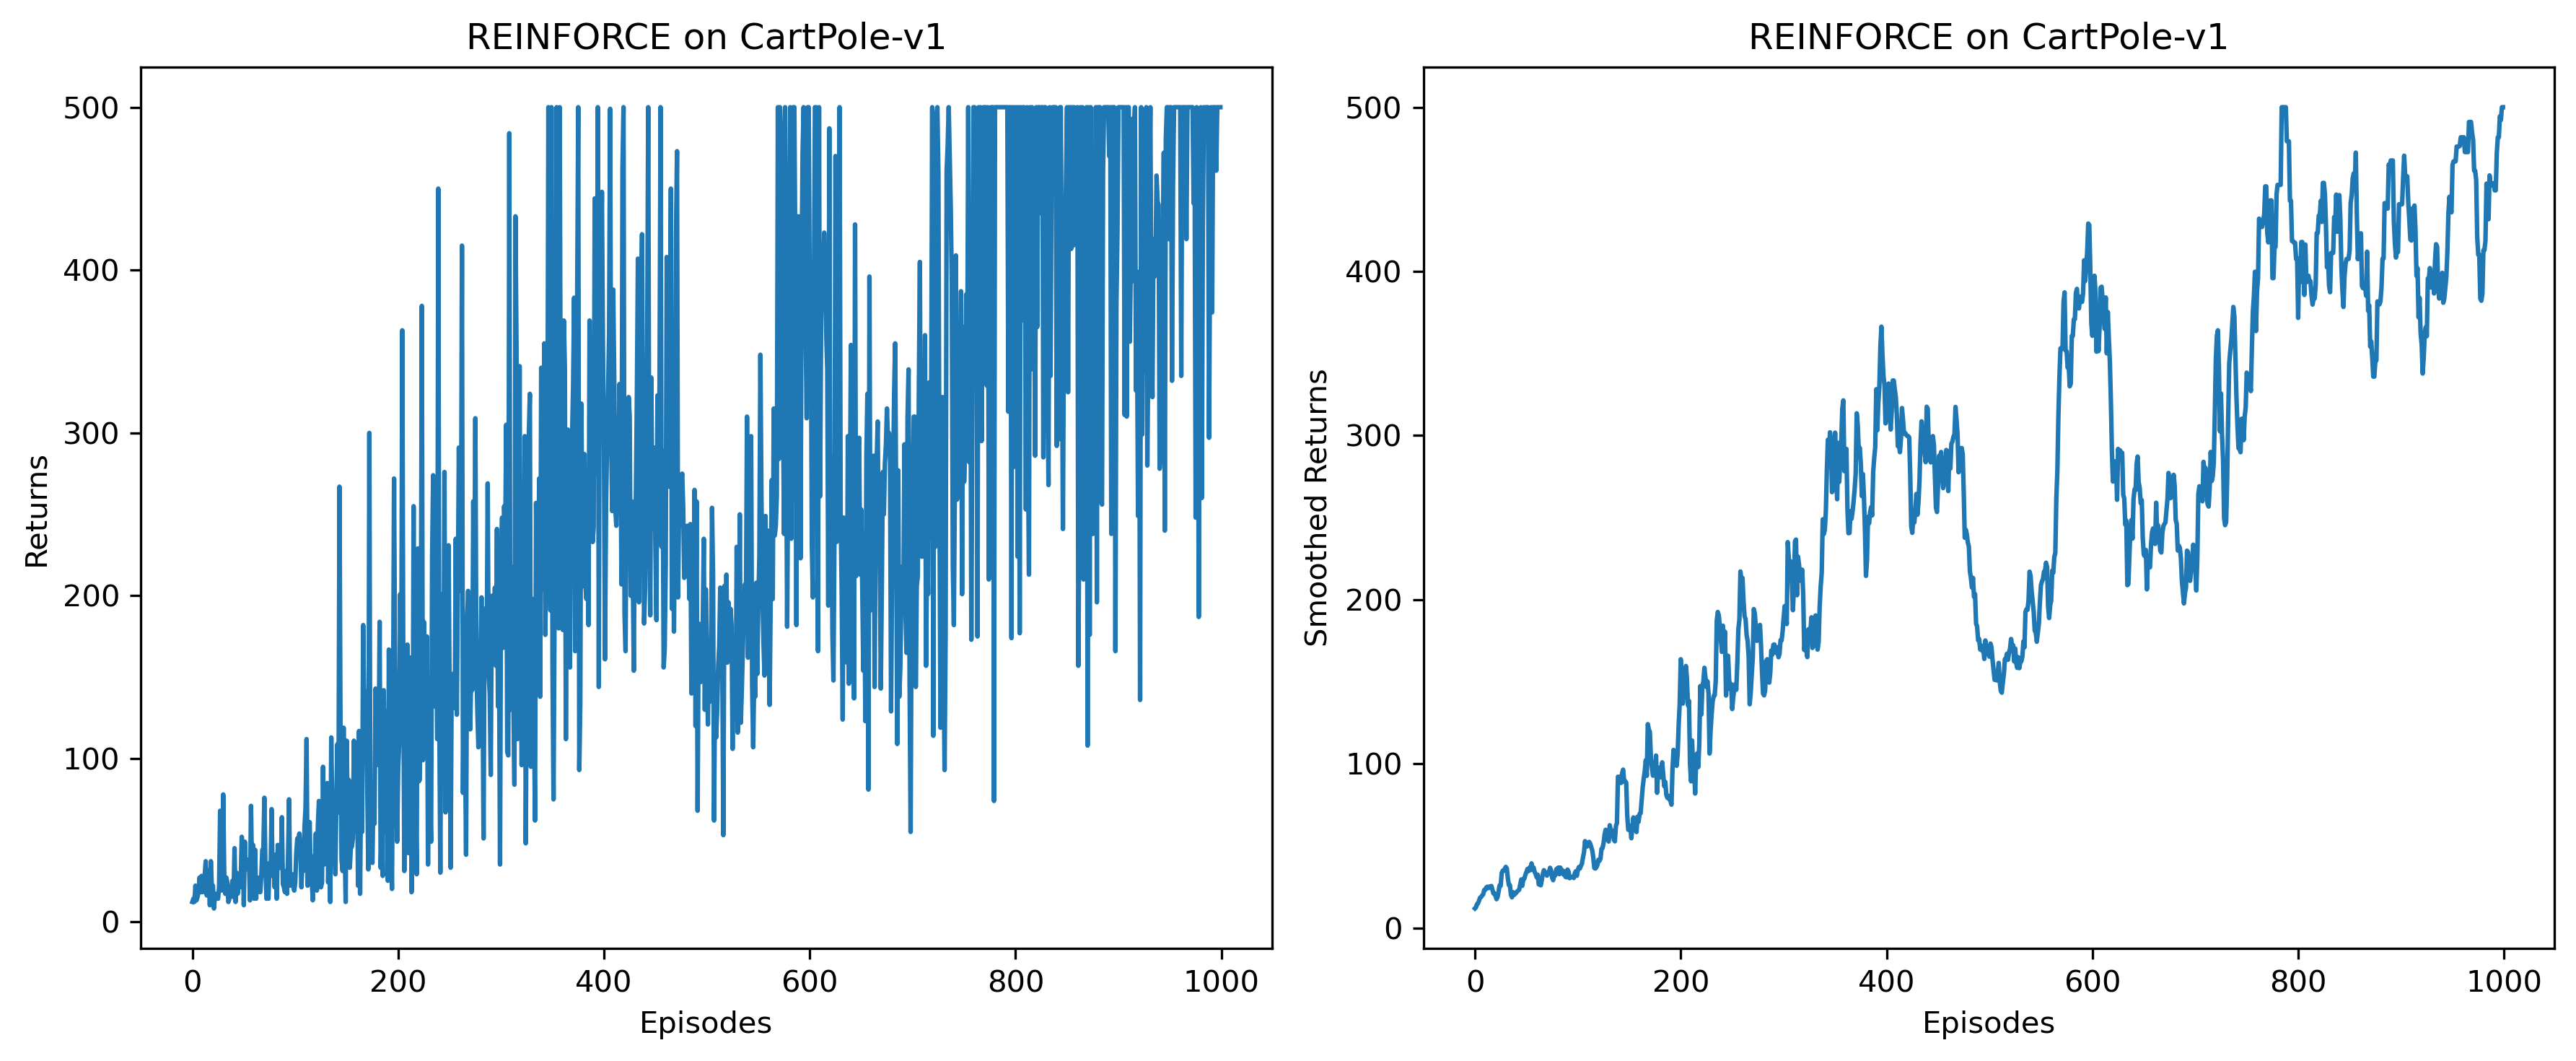

In [ ]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9) # 回报波动大 进行平滑处理
    
plt.figure(figsize=(12, 5), dpi = 300)

plt.subplot(1, 2, 1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'REINFORCE on {env_name}')

plt.subplot(1, 2, 2)
plt.plot(episodes_list, mv_return)  # 平滑处理的回报
plt.xlabel('Episodes')
plt.ylabel('Smoothed Returns')
plt.title(f'REINFORCE on {env_name}')
    
plt.tight_layout()
plt.show()

## 5.2 Actor-Critic
基于值函数的方法只学习一个价值函数，而基于策略的方法只学习一个策略函数。那么，一个很自然的问题是，有没有什么方法既学习价值函数，又学习策略函数呢？答案就是 Actor-Critic。Actor-Critic 是囊括一系列算法的整体架构，目前很多高效的前沿算法都属于 Actor-Critic 算法，本章接下来将会介绍一种最简单的 Actor-Critic 算法。需要明确的是，Actor-Critic 算法本质上是基于策略的算法，因为这一系列算法的目标都是优化一个带参数的策略，只是会额外学习价值函数，从而帮助策略函数更好地学习。

In [ ]:
# 策略网络与REINFORCE一样
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)    # 输出动作概率

In [12]:
# 额外引入一个价值网络
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # 直接输出动作价值

In [ ]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络 actor负责更新策略
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 价值网络 critic负责估计价值
        self.critic = ValueNet(state_dim, hidden_dim).to(device)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):   # actor按照动作概率采样 和REINFORCE一样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标（计算更准确的当前状态的价值）
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))

        # .detach(): 切断梯度流 计算 actor_loss 时, 把 td_delta 当作一个固定的已知常数
        actor_loss = torch.mean(-log_probs * td_delta.detach()) 
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

In [ ]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state, _ = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    done = terminated or truncated
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list

In [25]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:03<00:00, 32.93it/s, episode=1000, return=500.000]


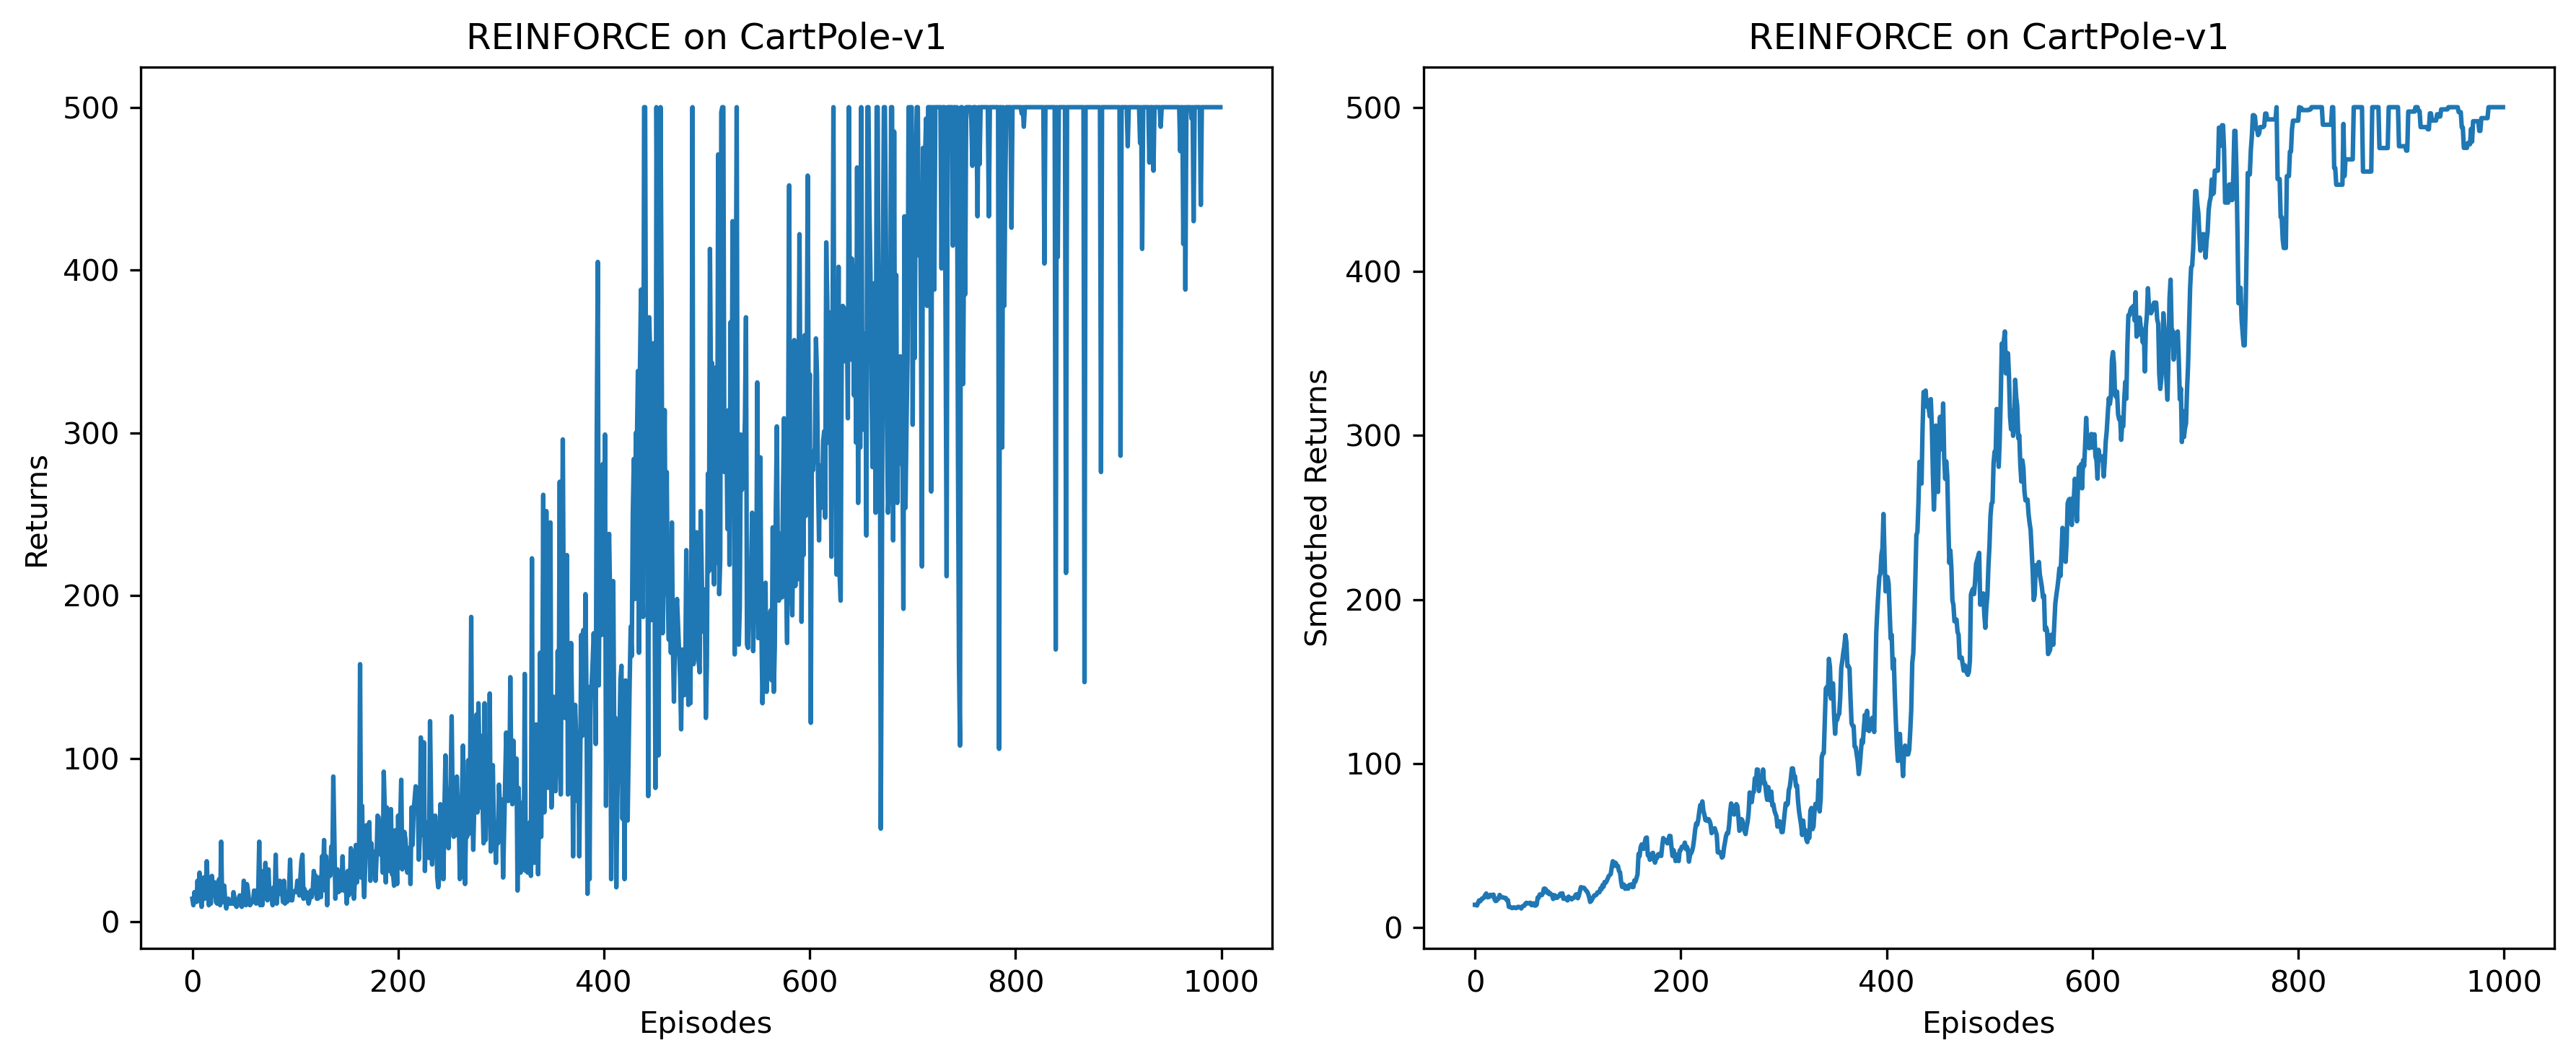

In [26]:
episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 9) # 回报波动大 进行平滑处理
    
plt.figure(figsize=(12, 5), dpi = 300)

plt.subplot(1, 2, 1)
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title(f'REINFORCE on {env_name}')

plt.subplot(1, 2, 2)
plt.plot(episodes_list, mv_return)  # 平滑处理的回报
plt.xlabel('Episodes')
plt.ylabel('Smoothed Returns')
plt.title(f'REINFORCE on {env_name}')
    
plt.tight_layout()
plt.show()

根据实验结果我们可以发现，Actor-Critic 算法很快便能收敛到最优策略，并且训练过程非常稳定，抖动情况相比 REINFORCE 算法有了明显的改进，这说明价值函数的引入减小了方差。